## The inheritance

We have an amount of property that we want to divide between two siblings.

```python
property_prices = [4, 8, 6, 3, 12, 15] # units in thousands of dollars
```

In our case, we have 6 different properties. We want to see if we can partition them into two sets that have the same value.

We will have 6 binary variables:

$x_i = 0$ if the i-th property goes to the first sibling.

$x_i = 1$ if the i-th property goes to the second sibling.
   
   
Steps:

1. We create a superposition of all possible asset allocations.
2. Through the oracle, we mark those distributions that satisfy the request.
3. We amplify the probability of observing solution states through Grover's operator.

In [1]:
import pennylane as qml
from pennylane import numpy as np

property_prices = [4, 8, 6, 3, 12, 15] # total 48 
variables_wires = [0, 1, 2, 3, 4, 5]


In [2]:
aux_oracle_wires = [6, 7, 8 ,9 ,10, 11]

def oracle(variables_wires, aux_oracle_wires):
    
    def add_k_fourier(k, wires):
        for j in range(len(wires)):
            qml.RZ(k * np.pi / (2**j), wires=wires[j])
            
    def value_second_sibling():
        
        qml.QFT(wires = aux_oracle_wires)
        
        for wire in variables_wires:
            qml.ctrl(add_k_fourier, control = wire)(property_prices[wire], wires = aux_oracle_wires)
            
        qml.adjoint(qml.QFT)(wires = aux_oracle_wires)
        
    value_second_sibling()
    qml.FlipSign(sum(property_prices) // 2, wires = aux_oracle_wires)
    qml.adjoint(value_second_sibling)()
    

In [3]:
dev = qml.device("default.qubit", wires = variables_wires + aux_oracle_wires)

@qml.qnode(dev)
def circuit():
    
    # step 1
    for wire in variables_wires:
        qml.Hadamard(wires = wire)
       
    # step 2
    oracle(variables_wires, aux_oracle_wires)
    
    # step 3
    qml.GroverOperator(wires = variables_wires)
    
    return qml.probs(wires = variables_wires)

<BarContainer object of 64 artists>

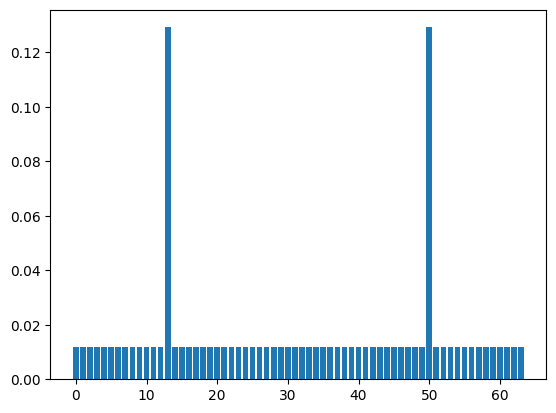

In [4]:
import matplotlib.pyplot as plt

values = circuit()
plt.bar(range(len(values)), values)